In [43]:
import numpy as np
# import pandas as pd
import matplotlib.pyplot as plt
import os
# import cv2
import random
import tensorflow as tf
from tensorflow import keras
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
import pandas as pd

# Audio processing
import librosa
import librosa.display
import audiomentations
from sklearn.neighbors import NearestNeighbors
from sklearn.preprocessing import StandardScaler, LabelEncoder
from keras_cv.layers import RandomCutout

In [16]:
emotions_tras = {1:1, 2:4, 3:5, 4:0, 5:3, 6:2, 7:6}   # to match the correct labels
emotions = {0:'angry', 1:'calm', 2:'disgust', 3:'fear', 4:'happy', 5:'sad', 6:'surprise'} 

# Paths
dataset_video_path = "Datasets/RAVDESS_frames_face/"
dataset_audio_path = "Other/audio_test/"
models_video_path = "Models/Video_Stream/"
models_audio_path = "Models/Audio_Stream/"

height_orig = 224
width_orig = 224
height_targ = 112
width_targ = 112

num_classes = len(emotions)

test_actors = ['21', '22', '23', '24']

## Data Preparation

#### Audio

In [17]:
X_test = np.load(dataset_audio_path + 'X_test.npy')
y_test = np.load(dataset_audio_path + 'y_test.npy')

#### Video

In [18]:
test_frames = []                                                               # test

for (root, dirs, files) in os.walk(dataset_video_path):
    if files != []:
        label_temp = int(files[0].split('-')[2]) - 1
        if label_temp != 0:                                                     # exclude 'neutral' label
            if any(actor in root for actor in test_actors):                     # select only test actors
                path = [os.path.join(root, frame) for frame in files]
                label = [emotions_tras[label_temp]] * len(files)                # emotion trasposition
                test_frames.append(list(zip(path, label)))
num_videos = len(test_frames)
num_videos

224

In [19]:
# function that randomly sampling the same amount of frames among the files to balance the data
def sampling(list_frames, num_frames_desired):
    frames_sampled = []
    for frame in list_frames:
        sampled_list = random.sample(frame, num_frames_desired)
        frames_sampled += sampled_list
    return (frames_sampled)

# Reads an image from a file, decodes it into a dense tensor, and resizes it to a fixed shape.
def parse_image(filename):
    image = tf.io.read_file(filename)
    image = tf.image.decode_jpeg(image, channels=1)
    image = tf.image.convert_image_dtype(image, dtype=tf.float16)
    image = tf.image.resize_with_crop_or_pad(image, height_orig, width_orig)
    image = tf.image.resize(image, [height_targ, width_targ])
    print('shape frames:', image.shape)
    return image

def load_dataset(filenames, batch_size):
    print("frames per video:", frames_per_vid) 
    batch_size = frames_per_vid                                   #every batch contains all the frames of each video

    filenames_sampled = sampling(filenames, frames_per_vid)
    #random.shuffle(filenames_sampled)                            #in test we dont want to shuffle

    names = [frame[0] for frame in filenames_sampled]              # we seperatie the name and label of balanced frames
    labels = [frame[1] for frame in filenames_sampled]

    names = tf.data.Dataset.from_tensor_slices(names)
    images = names.map(parse_image, num_parallel_calls=tf.data.experimental.AUTOTUNE)

    labels = [elem for elem in labels]
    labels = tf.data.Dataset.from_tensor_slices(labels)

    ds = tf.data.Dataset.zip((images, labels))

    #ds = ds.shuffle(buffer_size=1000)                        #in test we dont want to shuffle
    ds = ds.batch(batch_size)
    ds = ds.repeat()
    ds = ds.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

    frame_number = len(filenames_sampled)
    step_per_epoch = frame_number // batch_size
    print('frames number:', frame_number, '\nbatch size:', batch_size, '\nbatch number:', step_per_epoch)
    return ds, step_per_epoch

In [20]:
frames_per_vid = min([len(elem) for elem in test_frames])     # number of frames per clip in order to have balanced classes
test_ds, step_per_epoch_test = load_dataset(test_frames, frames_per_vid)

frames per video: 24
shape frames: (112, 112, 1)
frames number: 5376 
batch size: 24 
batch number: 224


## Load models

#### Audio

In [21]:
models_list = os.listdir(models_audio_path)
model_audio = keras.models.load_model(models_audio_path + models_list[0])
model_audio.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 126, 182, 64)      640       
                                                                 
 batch_normalization (BatchN  (None, 126, 182, 64)     256       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 63, 91, 64)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 61, 89, 128)       73856     
                                                                 
 batch_normalization_1 (Batc  (None, 61, 89, 128)      512       
 hNormalization)                                                 
                                                        

#### Video

In [22]:
models_list = os.listdir(models_video_path)
model_video = keras.models.load_model(models_video_path + models_list[0])
model_video.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 112, 112, 1)]     0         
                                                                 
 sequential (Sequential)     (None, 112, 112, 1)       0         
                                                                 
 conv2d (Conv2D)             (None, 112, 112, 32)      512       
                                                                 
 batch_normalization (BatchN  (None, 112, 112, 32)     128       
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 112, 112, 32)      0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 56, 56, 32)       0         
 )                                                           

## Predictions

#### Audio

In [23]:
loss_audio, acc_audio = model_audio.evaluate(X_test,y_test)
print('accuracy at audio:', round(acc_audio, 4))

7/7 [==============================] - 2s 216ms/step - loss: 2.0700 - accuracy: 0.6429
accuracy at audio: 0.6429


In [24]:
pred_audio = model_audio.predict(X_test)
ground_audio = np.argmax(y_test, axis = 1)

7/7 [==============================] - 2s 221ms/step


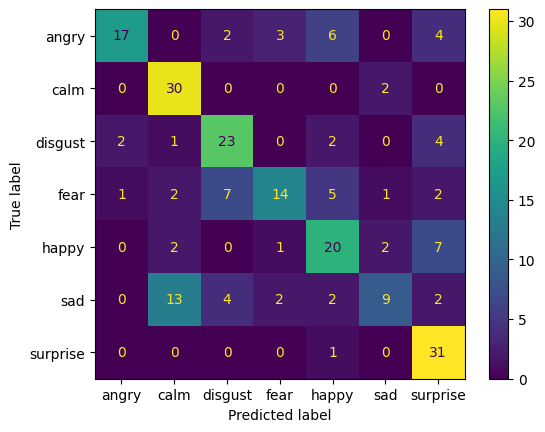

In [25]:
cm_audio = confusion_matrix(ground_audio, pred_audio.argmax(axis=1))
disp = ConfusionMatrixDisplay(cm_audio, display_labels=list(emotions.values()))
disp.plot()

In [26]:
y_pred = model_audio.predict(X_test)
y_pred_ = np.argmax(y_pred, axis = 1)
y_test_ = np.argmax(y_test, axis = 1)
print(classification_report(y_test_, y_pred_))

7/7 [==============================] - 2s 236ms/step
              precision    recall  f1-score   support

           0       0.85      0.53      0.65        32
           1       0.62      0.94      0.75        32
           2       0.64      0.72      0.68        32
           3       0.70      0.44      0.54        32
           4       0.56      0.62      0.59        32
           5       0.64      0.28      0.39        32
           6       0.62      0.97      0.76        32

    accuracy                           0.64       224
   macro avg       0.66      0.64      0.62       224
weighted avg       0.66      0.64      0.62       224



#### Video

Single Frame

In [27]:
#test_ds = test_ds.map(lambda x, y: (tf.repeat(x,3,-1),y)) #only when our saved model is transfer learning

In [28]:
loss_single_frame, acc_single_frame = model_video.evaluate(test_ds, steps=step_per_epoch_test)
print('accuracy at single frame:', round(acc_single_frame, 4))

224/224 [==============================] - 37s 155ms/step - loss: 2.4036 - sparse_categorical_accuracy: 0.4952
accuracy at single frame: 0.4952


In [29]:
pred_single_frame = model_video.predict(test_ds, steps=step_per_epoch_test).argmax(axis=1)
ground_single_frame = [elem[0][1]  for elem in test_frames]
ground_single_frame = np.repeat(ground_single_frame, frames_per_vid)

224/224 [==============================] - 22s 100ms/step


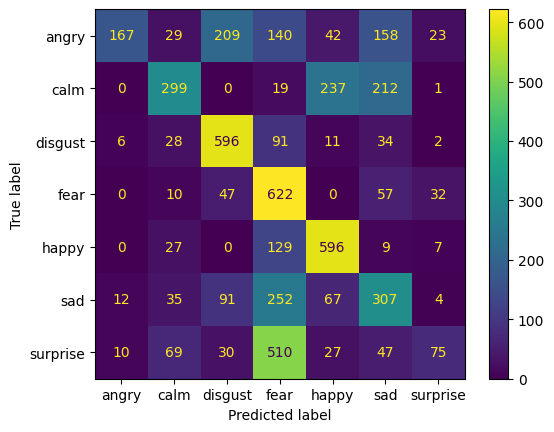

In [30]:
cm = confusion_matrix(ground_single_frame, pred_single_frame)
disp = ConfusionMatrixDisplay(cm, display_labels=list(emotions.values()))
disp.plot()

In [31]:
print(classification_report(ground_single_frame, pred_single_frame))

              precision    recall  f1-score   support

           0       0.86      0.22      0.35       768
           1       0.60      0.39      0.47       768
           2       0.61      0.78      0.68       768
           3       0.35      0.81      0.49       768
           4       0.61      0.78      0.68       768
           5       0.37      0.40      0.39       768
           6       0.52      0.10      0.16       768

    accuracy                           0.50      5376
   macro avg       0.56      0.50      0.46      5376
weighted avg       0.56      0.50      0.46      5376



Full video

In [32]:
pred_video_frames = model_video.predict(test_ds, steps=step_per_epoch_test)

224/224 [==============================] - 22s 99ms/step


In [33]:
pred_video_list = np.array_split(pred_video_frames, num_videos)

ground_video = []
pred_video = []

i = 0
for count, video in enumerate(pred_video_list):
    pred_video.append(np.mean(video, axis=0))
    ground_video.append(test_frames[count][0][1])
    
    if np.array(pred_video[count]).argmax() == ground_video[count]:
        i += 1

pred_video = np.array(pred_video)
print('accuracy full video:\t', round(i/len(pred_video_list), 4))
print('Num videos:\t\t', count+1)

accuracy full video:	 0.5312
Num videos:		 224


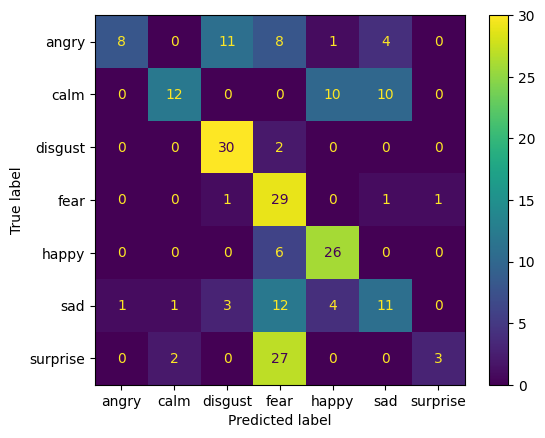

In [34]:
cm_video = confusion_matrix(ground_video, pred_video.argmax(axis=1))
disp = ConfusionMatrixDisplay(cm_video, display_labels=list(emotions.values()))
disp.plot()

In [35]:
print(classification_report(ground_video, pred_video.argmax(axis=1)))

              precision    recall  f1-score   support

           0       0.89      0.25      0.39        32
           1       0.80      0.38      0.51        32
           2       0.67      0.94      0.78        32
           3       0.35      0.91      0.50        32
           4       0.63      0.81      0.71        32
           5       0.42      0.34      0.38        32
           6       0.75      0.09      0.17        32

    accuracy                           0.53       224
   macro avg       0.64      0.53      0.49       224
weighted avg       0.64      0.53      0.49       224



## Fusion

Lare Fusion. This approach  involves combining the prediction from audio and video models trained on each modality separetely.

#### Posterior probability sum

In [36]:
pred_global = pred_video + pred_audio # mean
ground_global = ground_audio

In this approach, the predictions from both the pred_video and pred_audio modalities are multiplied element-wise for each class, and then the square root of the resulting values is taken. This process ensures that the fused prediction maintains the multiplicative relationships between probabilities while combining the information from both modalities. The square root is used to scale down the values, as the product of probabilities can grow quite large. The geometric mean fusion is often used when dealing with probabilities to create a balanced fusion that takes into account the strength of predictions from both modalities.

#### Geometric Mean Fusion


In [37]:
pred_global = np.sqrt(pred_video * pred_audio)

In [38]:
pred_global

array([[7.4839925e-05, 1.7639723e-01, 3.6762899e-04, ..., 2.3823170e-01,
        8.6184531e-02, 2.4499248e-03],
       [9.1301226e-06, 2.3619048e-01, 5.1923166e-04, ..., 3.8845256e-01,
        1.4543453e-03, 2.2945046e-02],
       [2.0248481e-05, 3.4993067e-01, 4.5574438e-05, ..., 2.3356745e-01,
        2.3250230e-02, 1.1398186e-02],
       ...,
       [4.3790220e-05, 2.9438304e-06, 1.6312385e-02, ..., 3.8229692e-04,
        3.4952000e-06, 1.5601949e-01],
       [4.5456763e-05, 3.0375470e-05, 2.1849165e-03, ..., 1.1399827e-03,
        2.1193709e-06, 1.5909152e-01],
       [4.4888299e-07, 1.3224262e-05, 7.1963746e-05, ..., 4.8627792e-04,
        4.9862695e-07, 3.2079646e-01]], dtype=float32)

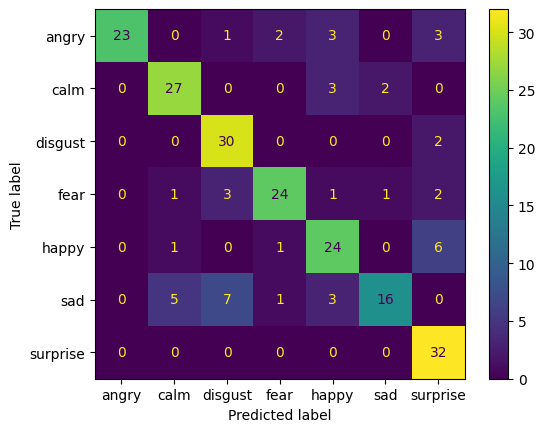

In [39]:
cm_global = confusion_matrix(ground_global, pred_global.argmax(axis=1))
disp = ConfusionMatrixDisplay(cm_global, display_labels=list(emotions.values()))
disp.plot()

In [40]:
print(classification_report(ground_global, pred_global.argmax(axis=1)))

              precision    recall  f1-score   support

           0       1.00      0.72      0.84        32
           1       0.79      0.84      0.82        32
           2       0.73      0.94      0.82        32
           3       0.86      0.75      0.80        32
           4       0.71      0.75      0.73        32
           5       0.84      0.50      0.63        32
           6       0.71      1.00      0.83        32

    accuracy                           0.79       224
   macro avg       0.81      0.79      0.78       224
weighted avg       0.81      0.79      0.78       224



#### Attention Mechanism Fusion
Apply attention mechanisms to the probabilities from both modalities to dynamically adjust their contributions based on the context of the input data.

In [99]:
# Calculate attention weights for each modality
attention_weights_audio = np.mean(pred_audio, axis=1)
attention_weights_video = np.mean(pred_video, axis=1)

# Softmax attention weights
attention_weights_audio = np.exp(attention_weights_audio) / np.sum(np.exp(attention_weights_audio))
attention_weights_video = np.exp(attention_weights_video) / np.sum(np.exp(attention_weights_video))

# Weighted sum of modality predictions using attention
pred_global = np.sqrt(attention_weights_audio.reshape(-1, 1) * pred_audio) * (attention_weights_video.reshape(-1, 1) * pred_video)

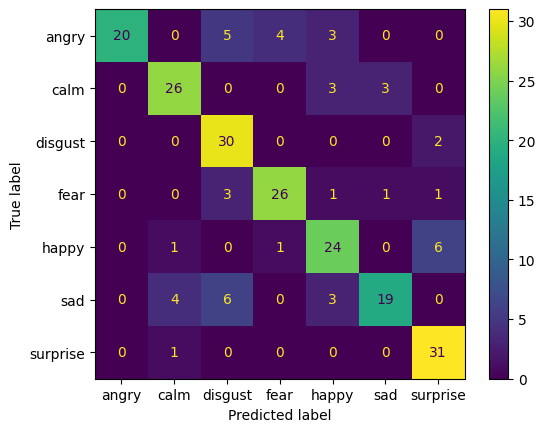

In [100]:
cm_global = confusion_matrix(ground_global, pred_global.argmax(axis=1))
disp = ConfusionMatrixDisplay(cm_global, display_labels=list(emotions.values()))
disp.plot()

In [101]:
print(classification_report(ground_global, pred_global.argmax(axis=1)))

              precision    recall  f1-score   support

           0       1.00      0.62      0.77        32
           1       0.81      0.81      0.81        32
           2       0.68      0.94      0.79        32
           3       0.84      0.81      0.83        32
           4       0.71      0.75      0.73        32
           5       0.83      0.59      0.69        32
           6       0.78      0.97      0.86        32

    accuracy                           0.79       224
   macro avg       0.81      0.79      0.78       224
weighted avg       0.81      0.79      0.78       224



#### Ensemble Learning
Ater we separated models on each modality's data, and then we combine their predictions using ensemble methods like majority voting.

In [80]:
from scipy.stats import mode
# Combine predictions using majority voting
ensemble_predictions = np.sum(np.stack((pred_audio, pred_video)), axis=0)
# Get the most common prediction across models
majority_vote_predictions = mode([ensemble_predictions])[0][0]

C:\Users\leofr\AppData\Local\Temp\ipykernel_20728\1648403466.py:5: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  majority_vote_predictions = mode([ensemble_predictions])[0][0]


In [82]:
majority_vote_predictions.shape

(224, 7)

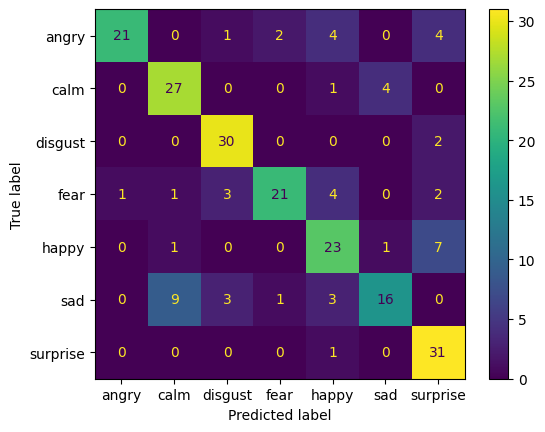

In [83]:
cm_global = confusion_matrix(ground_global, majority_vote_predictions.argmax(axis=1))
disp = ConfusionMatrixDisplay(cm_global, display_labels=list(emotions.values()))
disp.plot()

In [84]:
print(classification_report(ground_global, majority_vote_predictions.argmax(axis=1)))

              precision    recall  f1-score   support

           0       0.95      0.66      0.78        32
           1       0.71      0.84      0.77        32
           2       0.81      0.94      0.87        32
           3       0.88      0.66      0.75        32
           4       0.64      0.72      0.68        32
           5       0.76      0.50      0.60        32
           6       0.67      0.97      0.79        32

    accuracy                           0.75       224
   macro avg       0.78      0.75      0.75       224
weighted avg       0.78      0.75      0.75       224



F1-scor

In [93]:
normalized_f1_video.shape

(7,)

In [106]:
# Example F1-scores for each label and modality
f1_scores_audio = np.array([0.65, 0.75, 0.68, 0.54, 0.59, 0.39, 0.76])  # F1-scores for each label for audio modality
f1_scores_video = np.array([0.39, 0.51, 0.78, 0.50, 0.71, 0.38, 0.17])  # F1-scores for each label for video modality

# Normalize F1-scores to sum to 1
normalized_f1_audio = f1_scores_audio / np.sum(f1_scores_audio)
normalized_f1_video = f1_scores_video / np.sum(f1_scores_video)

# Calculate weighted probabilities using normalized F1-scores
weighted_probs_audio = normalized_f1_audio * pred_audio
weighted_probs_video = normalized_f1_video * pred_video

# Combine weighted probabilities using a simple average
final_probs = (weighted_probs_audio + weighted_probs_video) / 2

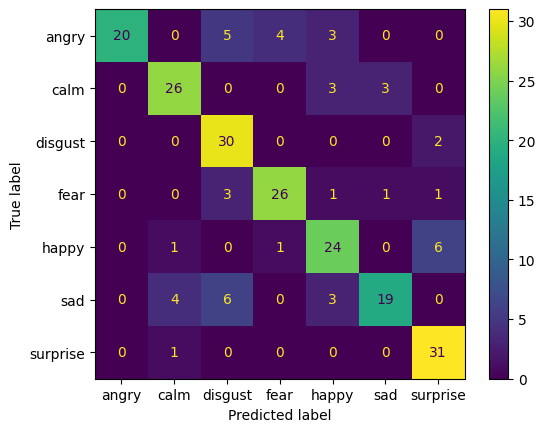

In [107]:
cm_global = confusion_matrix(ground_global, pred_global.argmax(axis=1))
disp = ConfusionMatrixDisplay(cm_global, display_labels=list(emotions.values()))
disp.plot()

In [104]:
print(classification_report(ground_global, final_probs.argmax(axis=1)))

              precision    recall  f1-score   support

           0       1.00      0.66      0.79        32
           1       0.77      0.84      0.81        32
           2       0.62      0.94      0.75        32
           3       0.86      0.75      0.80        32
           4       0.71      0.75      0.73        32
           5       0.87      0.41      0.55        32
           6       0.74      1.00      0.85        32

    accuracy                           0.76       224
   macro avg       0.80      0.76      0.75       224
weighted avg       0.80      0.76      0.75       224

